<a href="https://colab.research.google.com/github/rchllllll/cp5105-capstone-proj/blob/main/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade matplotlib

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import pickle
import os
from pathlib import Path
import time 
import collections

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader 
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
transforms = nn.Sequential(
  T.Resize((228, 228))
)

In [4]:
# configurations 
IMAGES_DATA_DIR = "./drive/MyDrive/capstone/train/"

NUM_SAMPLES = 1028
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 100
EMB_SIZE = 100

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
class SiameseDataset(Dataset): 

  def __init__(self, images_folder_path, transform=None, num_samples=10, **kwargs):
    self.images_folder_path = images_folder_path
    self.transform = transform
    self.num_samples = num_samples

    self.class_names = [name for name in os.listdir(self.images_folder_path) if os.path.isdir(os.path.join(self.images_folder_path, name))]
    self.all_images = [[self.class_names[i] + "/" + name for name in os.listdir(self.images_folder_path + self.class_names[i])] for i in range(len(self.class_names))]

    self.data = self.create_dataset()

  def __getitem__(self, index):

    img1 = read_image(str(Path(self.images_folder_path) / self.data[0][index]))
    img2 = read_image(str(Path(self.images_folder_path) / self.data[1][index]))

    if self.transform is not None:
      img1_transformed = self.transform(img1)
      img2_transformed = self.transform(img2)

    return img1_transformed, img2_transformed, self.data[2][index], self.data[3][index], self.data[4][index]

  def __len__(self): 
      return self.num_samples

  def get_sample(self):
    get_same_class = np.random.randint(0, 2, size=self.num_samples) 
    image_one_class = np.random.randint(0, len(self.class_names), size=self.num_samples)
    image_two_class = [
      np.random.choice(
        [x for x in range(len(self.class_names)) if x != image_one_class[i]]
      ) 
      if get_same_class[i] == 0 else image_one_class[i] for i in range(self.num_samples)
    ]

    # to do: images 1 and 2 may be the same photo when the classes are the same 
    image_one = list(map(lambda x: random.choice(self.all_images[x]), image_one_class))
    image_two = list(map(lambda x: random.choice(self.all_images[x]), image_two_class))

    return image_one, image_two, image_one_class, image_two_class, get_same_class

  def create_dataset(self): 
    x1, x2, c1, c2, y = self.get_sample()
    return x1, x2, c1, c2, y

In [6]:
def show(imgs):
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
    img = T.ToPILImage()(img.to(DEVICE))
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

tensor([0, 1, 1, 0, 1, 1, 1, 1])
time 2.9916966240000002


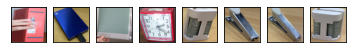

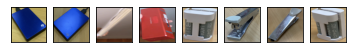

In [7]:
start = time.process_time()

sampleset = SiameseDataset(images_folder_path=IMAGES_DATA_DIR, transform=transforms, num_samples=16)
sampleloader = DataLoader(sampleset, batch_size = 8)
dataiter = iter(sampleloader)
samplebatch = next(dataiter)

x, y, _, _, z = samplebatch
show(x)
show(y)
print(z)

print('time', time.process_time() - start)

In [8]:
full_dataset = SiameseDataset(images_folder_path=IMAGES_DATA_DIR, transform=transforms, num_samples=NUM_SAMPLES)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset,
                        shuffle = True,
                        num_workers = 2, 
                        batch_size = BATCH_SIZE)
valloader = DataLoader(val_dataset,
                       shuffle = False,
                       num_workers = 2,
                       batch_size = BATCH_SIZE)

In [9]:
train_size, val_size

(822, 206)

In [10]:
with open(f'drive//MyDrive//capstone//data//train_dataset_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pickle', 'wb') as handle:
  pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'drive//MyDrive//capstone//data//val_dataset_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pickle', 'wb') as handle:
  pickle.dump(val_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

eda

In [11]:
class_names = full_dataset.class_names

sampleloader = DataLoader(train_dataset, batch_size = train_size)
dataiter = iter(sampleloader)
img1, img2, img1class, img2class, label = next(dataiter)

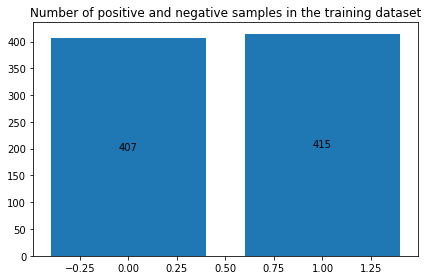

In [12]:
counter = collections.Counter(label.numpy())

fig, ax = plt.subplots()

p = plt.bar(counter.keys(), counter.values())
plt.bar_label(p, label_type='center')

ax.set_title("Number of positive and negative samples in the training dataset")
fig.tight_layout()
plt.show()

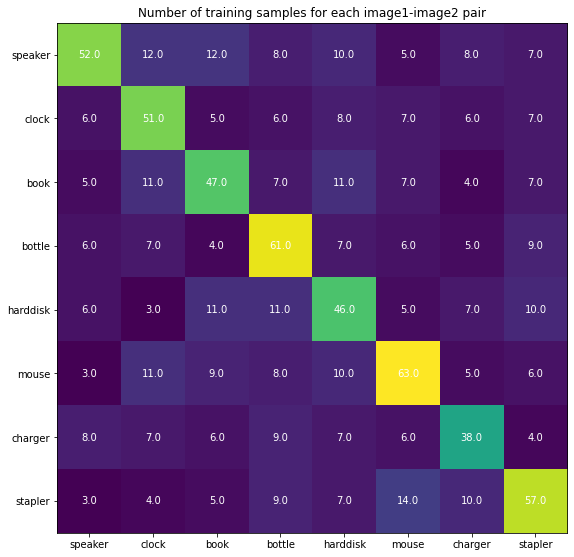

In [13]:
d = dict()

one = img1class.numpy()
two = img2class.numpy()
num_classes = len(np.unique(one))

res = np.zeros((num_classes, num_classes))

for l in range(len(one)): 
  res[one[l], two[l]] += 1

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)

ax.imshow(res)

ax.set_xticks(np.arange(num_classes), labels=class_names)
ax.set_yticks(np.arange(num_classes), labels=class_names)

for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, res[i, j], ha="center", va="center", color="w")

ax.set_title("Number of training samples for each image1-image2 pair")
fig.tight_layout()
plt.show()

model training

In [14]:
class SiameseModel(nn.Module):
  
  def __init__(self, emb_size = EMB_SIZE): 
    super(SiameseModel, self).__init__()

    self.weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
    self.siamese = efficientnet_v2_s(weights=self.weights)
    self.siamese.classifier = nn.Sequential(
        nn.Linear(self.siamese.classifier[1].in_features, 500),
        nn.ReLU(inplace = True),
        nn.Linear(500, emb_size)
    )
    self.classifier = nn.Sequential(
        nn.Linear(emb_size, 1),
        nn.Sigmoid()
    )

  def forward(self, img1, img2): 
    preprocess = self.weights.transforms()
    x1 = preprocess(img1)
    x2 = preprocess(img2)
    out1 = self.siamese(x1)
    out2 = self.siamese(x2)
    # multiply to get combined feature vector representing the similarity btwn the two
    combined_features = out1 * out2
    output = self.classifier(combined_features)
    return output

In [15]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    # Calculate the euclidean distance and calculate the contrastive loss
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [16]:
model = SiameseModel()
model.to(DEVICE)

baseline_model = SiameseModel()
baseline_model.to(DEVICE)

# criterion = ContrastiveLoss()
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

In [17]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0
best_vloss = 1_000_000.
train_loss_history = []
val_loss_history = []

In [ ]:
for epoch in range(500):

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)

  tloss_history = []
  tcorrect = 0
  ttotal = 0
  for _, data in enumerate(trainloader):
    img0, img1, _, _, label = data
    img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.float().to(DEVICE)
    optimizer.zero_grad()
    
    output = model(img0, img1).squeeze(1)
    loss = criterion(output, label)

    tcorrect += torch.count_nonzero(label == (output > 0.5)).item()
    ttotal += len(label)

    loss.backward()
    optimizer.step()
    tloss_history.append(loss.item())

  # We don't need gradients on to do reporting
  model.train(False)

  # Do validation
  vloss_history = []
  vcorrect = 0
  vtotal = 0
  with torch.no_grad():
    for _, vdata in enumerate(valloader):
      vimg0, vimg1, _, _, vlabel = vdata
      vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.float().to(DEVICE)
    
      voutput = model(vimg0, vimg1).squeeze(1)
      vloss = criterion(voutput, vlabel)
      
      vcorrect += torch.count_nonzero(vlabel == (voutput > 0.5)).item()
      vtotal += len(vlabel)

      vloss_history.append(vloss.item())

  # Calculate train and val loss 
  avg_tloss = np.mean(tloss_history)
  avg_vloss = np.mean(vloss_history)
  avg_tacc = tcorrect / ttotal
  avg_vacc = vcorrect / vtotal
  
  if epoch % 10 == 0:
    print(f'[{time.ctime()}] [Epoch {epoch_number}] train loss: {avg_tloss:.3f} val loss: {avg_vloss:.3f} train acc: {avg_vloss:.3f} val acc: {avg_vacc:.3f}')

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = f'drive//MyDrive//capstone//model//siamese_model_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pth'
    torch.save(model.state_dict(), model_path)

  train_loss_history.append(tloss_history)
  val_loss_history.append(vloss_history)

  if epoch+1 % 50 == 0:
    # save the progress 
    model_path = f'drive//MyDrive//capstone//model//siamese_model_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pth'
    torch.save(model.state_dict(), model_path)
    with open(f'drive//MyDrive//capstone//model//train_loss_history_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pickle', 'wb') as handle:
      pickle.dump(train_loss_history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'drive//MyDrive//capstone//model//val_loss_history_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}_emb{EMB_SIZE}.pickle', 'wb') as handle:
      pickle.dump(val_loss_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

  epoch_number += 1

[Sat Sep 24 16:19:17 2022] [Epoch 1] train loss: 0.315 val loss: 0.261 train acc: 0.261 val acc: 0.898


In [ ]:
# save the progress 
with open(f'drive//MyDrive//capstone//model//train_loss_history_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}.pickle', 'wb') as handle:
  pickle.dump(train_loss_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'drive//MyDrive//capstone//model//val_loss_history_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}.pickle', 'wb') as handle:
  pickle.dump(val_loss_history, handle, protocol=pickle.HIGHEST_PROTOCOL) 

# make sure the latest model is saved 
model_path = f'drive//MyDrive//capstone//model//siamese_model_e{epoch_number}_b{BATCH_SIZE}_lr{LR}_num{NUM_SAMPLES}.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
plt.plot(range(len(train_loss_history)), [np.mean(x) for x in train_loss_history])
plt.show()

In [ ]:
plt.plot(range(len(val_loss_history)), [np.mean(x) for x in val_loss_history])
plt.show()

model testing

In [ ]:
TEST_DATA_DIR = "./drive/MyDrive/capstone/test/"
TEST_SAMPLES = 128

testset = SiameseDataset(images_folder_path=TEST_DATA_DIR, transform=transforms, num_samples=TEST_SAMPLES)
testloader = DataLoader(testset,
                        shuffle = True,
                        batch_size = 1)

dataiter = iter(testloader)
samplebatch = next(dataiter)

x, y, _, _, z = samplebatch
show(x)
show(y)
print(z)

In [ ]:
threshold = 0.5

model_correct = 0 
baseline_model_correct = 0 
total = 0

with torch.no_grad():
  for _, vdata in enumerate(testloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    vout0, vout1 = model(vimg0, vimg1)
    euclidean_distance = F.pairwise_distance(vout0, vout1)

    b_vout0, b_vout1 = baseline_model(vimg0, vimg1)
    b_euclidean_distance = F.pairwise_distance(b_vout0, b_vout1)

    model_correct += sum((euclidean_distance > threshold).float() == vlabel)
    baseline_model_correct += sum((b_euclidean_distance > threshold).float() == vlabel)

    total += vlabel.shape[0]

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)